<a href="https://colab.research.google.com/github/clkim/IntroNeuralNetworksDeepLearningPart2IEEEBoston/blob/20250419class/Copy_of_makemore_part5_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building makemore Part 5 - character-level language model with a tree-like structure

Class acknowledgement: This Colab Jupyter Notebook for our Part 2 class' Section 2: *Basic Language Modeling* is from the video lecture *Building makemore Part 5: Building a WaveNet* that is sixth in the awesome eight-part series [Neural Networks: Zero to Hero, by Andrej Karpathy](hhttps://karpathy.ai/zero-to-hero.html). The link to Andrej's colab notebook is given in the description of his lecture's YouTube video.

## Introduction to Neural Networks and Deep Learning (Part 2)

### Section 2: Basic Language Modeling

We will build a simple *character*-level language model that will receive eight previous characters as input context (block size or context length), and try to predict the next character in the sequence.

We will end up with a deep neural network, aka multilayer perceptron (MLP), whose architecture follows the tree-like structure of [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio). WaveNet is basically a language model but it tries to predict audio sequences instead of text sequences.

The title of Andrej's sixth video lecture is actually somewhat misleading because the lecture does not end up implementing the convolutional layers in WaveNet. (It seems clear he intended to cover that but he did not get to it, yet, for some reasaon.)

So we *won't* be looking into WaveNet, whose architecture is essentially a stack of convolutional layers and no pooling layers.

Nevertheless, it is still quite apt to adopt Andrej's sixth video for this basic language modeling section of our class, because it lays the groundwork for his superb *Let's build GPT: from scratch, in code, spelled out* seventh video lecture covering GPT and Large Language Models.

Our model is similar to WaveNet in that it is an auto-regressive model i.e. it tries to predict the next item (character) in a sequence, and it has a hierarchical-layer approach.

The material in this Jupyter Notebook, taken from the sixth video lecture, builds on his third video lecture *Building makemore Part 2: MLP* which implements an even simpler neural network language model, and has context length of just three characters (loosely based on [Figure 1 in the paper A Neural Probabilistic Language Model by Yoshua Bengio, et. al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)).


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
#%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
#chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

In [ ]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:        # initially missed setting dim for this case
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 (not 300, a typo error) # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
#@title Class scratchpad 1
'''
# minibatch construct
batch_size = 4
ix = torch.randint(0, Xtr.shape[0], (batch_size,))  ## will just keep context block size at 8 and not 3 at start of video lecture
Xb, Yb = Xtr[ix], Ytr[ix]
print(Xb.shape, Yb.shape) # torch.Size([4, 8]) torch.Size([4])

# forward pass
## Sequential
### Embedding
num_embeddings = 27 # vocab_size
embedding_dim = 10  # n_embd
weight = torch.randn((num_embeddings, embedding_dim))
IX = Xb
out = weight[IX]
print(out.shape) # torch.Size([4, 8, 10])

### FlattenConsecutive
n = 8
B, T, C = out.shape  ## B: mini-batch size, T: (time) sequence or context length, C: # channels or features
out = out.view(B, T//n, C*n)
print(out.shape) # torch.Size([4, 1, 10*8])
out = out.squeeze(1)
print(out.shape) # torch.Size([4, 10*8])

### Linear
fan_in = 80
fan_out = 200  ## n_hidden initially at start of video lecture was 200, not 300 (typo)
weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
bias = None    ## batch normalization will remove the bias anyway
x = out
out = x @ weight
if bias is not None:
  out += bias
print(out.shape) # torch.Size([4, 200])

### BatchNorm1d
"""
Purpose:
  Normalize the input x feature/column across the batch
  Helps with: Faster training, regularization, reducing sensitive to weight initialization
Commentary:
  Batch normalization seems rarely used in modern LLMs such as Transformers
  One reason: less well suited for variable sequence lengths (# columns, within a batch)
  (Instead, Layer normalization is used)
  Convolutional Neural Networkss (such as ResNet) still use batch normalization extensively
Implementation:
  Calculate the mean and variance for each feature column across the batch and use them to normalize the input x.
  A running mean and variance has to be stored, for use during evaluation (i.e. not during training).
  Needs a 'state' flag to be set to indicate processing in training or evaluation mode; prone to bugs.
"""
x = out
xmean = x.mean(0, keepdim=True)
xvar = x.var(0, keepdim=True)
eps = 1e-5
gamma = torch.ones(200)
beta = torch.zeros(200)
xhat = (x - xmean) / torch.sqrt(xvar + eps)
out = xhat * gamma + beta
print(out.shape) # torch.Size([4, 200])

### Tanh
x = out
out = torch.tanh(x)
print(out.shape) # torch.Size([4, 300])

### Linear
fan_in = 200
fan_out = 27
weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
bias = None
x = out
out = x @ weight
print(out.shape) # torch.Size([4, 27])

## loss function
logits = out  ## predictions

counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(batch_size), Yb].log().mean()
print(loss)

print(F.cross_entropy(logits, Yb))
'''

In [ ]:
#@title Class scratchpad 2
'''
# PyTorch does Tensor broadcasting
## Rules for broadcasting (reference: https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html)
### mimic what is coming into initial Linear layer with fan_in=80 fan_out=200
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)) .shape       # torch.Size([4, 200])

# PyTorch 'A@B' is 'torch.matmul(A,B)' matrix multiplication
## the dimensions to the left of the last dimension are treated as the "batch dimesion"
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)) .shape # torch.Size([4, 5, 6, 200])

### after Embedding layer, shape is torch.Size([4, 8, 10])
### reminder: we have context block size of 8 (here characters/indices): 1 2 3 4 5 6 7 8
### don't want to concatenate/squash all 8 at once, but two at a time: (1 2) (3 4) (5 6) (7 8)
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)) .shape    # torch.Size([4, 4, 200])

### that is what the first FlattenConsecutive layer would do, after the Embedding layer to feed into first Linear layer
'''

In [ ]:
#@title Class scratchpad 3
'''
# forward pass
print(Xb.shape) # torch.Size([4, 8])
print(Xb)
logits = model(Xb)

## look at output shape of all the layers; reminder: n_embd = 24, n_hidden = 128
print(logits.shape) # torch.Size([4, 27])
print(logits)
for layer in model.layers:
  print(layer.__class__.__name__, ':', str(tuple(layer.out.shape)))
'''

##### Class note: visualization image

###### Visualization of a stack of dilated causal convolutional layers

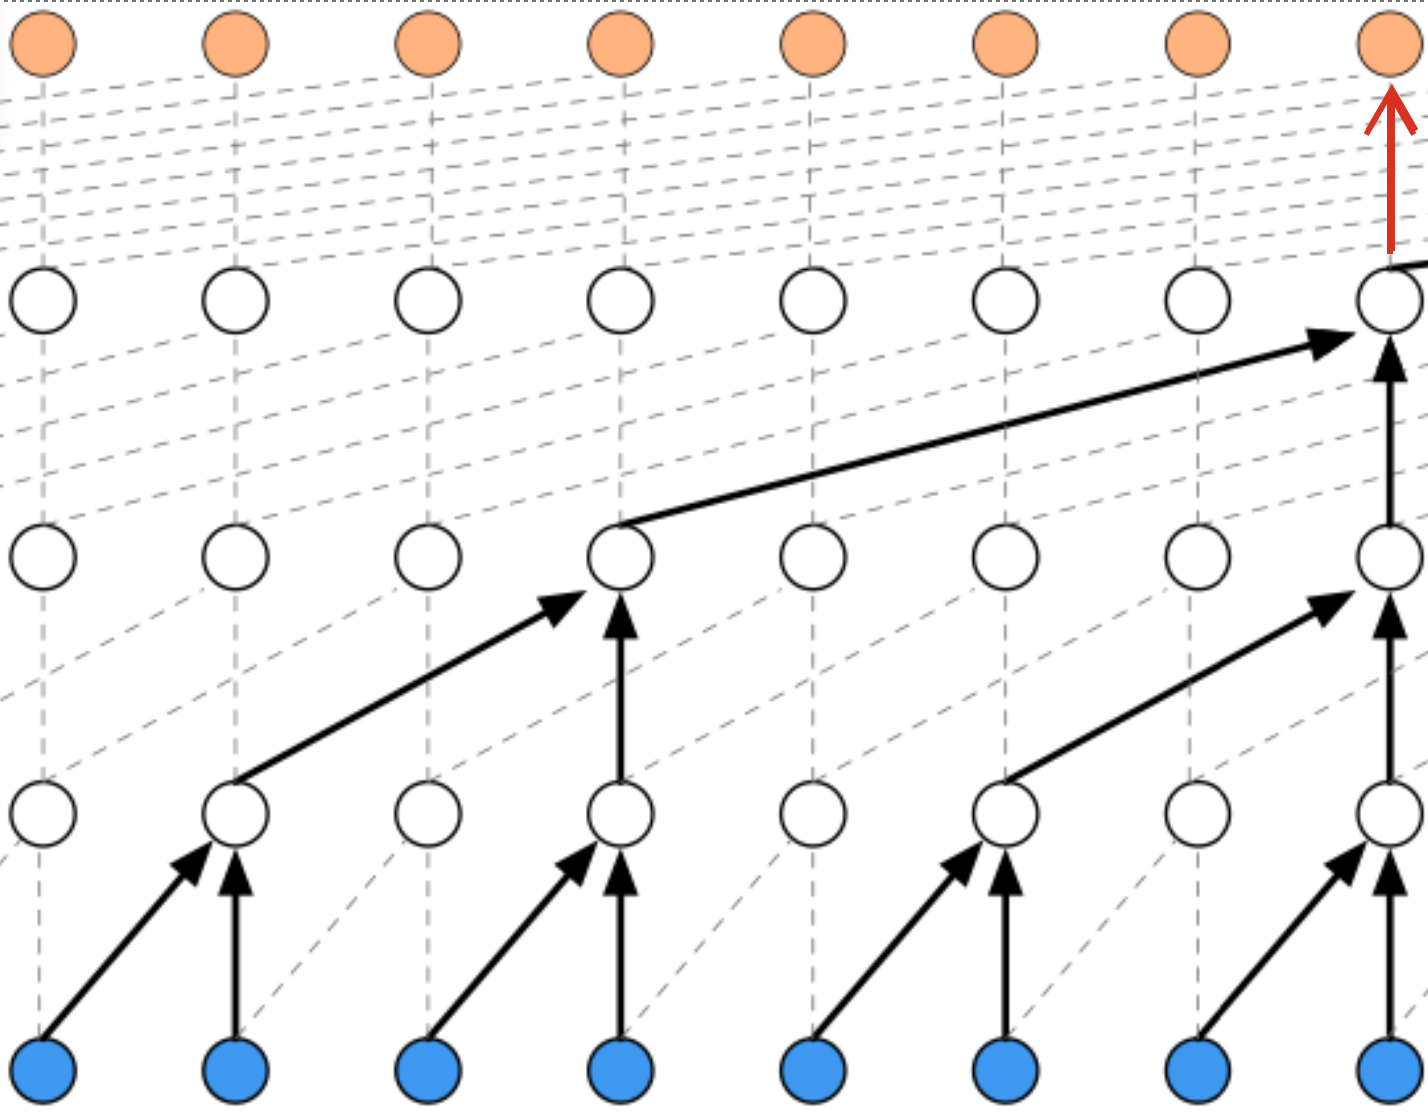

##### Class note: end visualization image

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

Class note  
Notice the effect of the learning rate decay we specified after iteration 150,000. It seems to reduce "overshooting" and allowed us to settle into the local minimum.

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


Class note  
Just to document, in the performance log tabulation, for the third run, the author kept number of params at 22K by keeping the embedding dimensions n_embd still at 10 but reducing the n_hidden to 68 instead of the 200 initially

In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

Class note:  
`model(Xtr[7])` gets ValueError because model expects a mini-batch size dimension, and `Xtr[7].shape` is just one-dimensional `torch.Size([8])`, while `Xtr[[7]].shape` is two-dimensional `torch.Size([1, 8])`

In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space

Class note  
The author says that the use of convolutionals as used in WaveNet is "strictly for efficiency". It does not actually change the model we implemented. To be clear, we did not implement any convolutionals in our simple language model; as I understand it, we simply adopted the idea of a stack of dilation to flatten the input in multiple passes.

But I cannot say I understand his above example of the for-loop iterating over eight inputs to obtain the eight logits, which he rightly pointed out would be eight independent calls to the model. He says convolutionals allow you to basically slide this model efficiently over the input sequence, and this for-loop can be done not outside in python, but inside of kernels in CUDA. He also mentions the convolutionals being able to reuse a node if it were a left-child and also a right-child of two nodes in the next layer up.

The only solace I take is that I believe the author did say at one point: "we're going to cover that in a future video".

So while I believe that the implementation in this notebook is not using convolutionals per se, the author seems to have planned on doing that in a future video (but has not done so).
